In [1]:
import os
from datasets import load_dataset
import os
import pandas as pd
import csv
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate
import matplotlib.pyplot as plt
import six
import re
import nltk
from nltk.corpus import words
from huggingface_hub import HfApi


c:\Users\Ruiya\anaconda3\envs\LLM_OnDevice\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Guidelines

1. Download our sample dataset
2. Run parallel representation
3. Run AFRN
4. Get visualization

#### 1 Download sample dataset

In this step, you can download our sample data for distress dataset.

The original dataset is './sample_data/textagon_sample/raw.txt'

Files other than the original dataset file are the outputs of parallel representations

In [1]:
import os
import gdown

# The URL of the Google Drive folder
folder_url = 'https://drive.google.com/drive/folders/1yWzE9sQLNx344WsNfjSzb8WZwb7-Fg95?usp=sharing'

# Specify the download location
download_location = './sample_data'

if os.path.exists(f'{download_location}/textagon_sample') == False:

    # Change the current working directory to the specified download location
    os.makedirs(download_location, exist_ok=True)
    os.chdir(download_location)

    # Use gdown to download the folder
    gdown.download_folder(folder_url, quiet=False)


#### 2. Run parallel representation


##### Arguments:
1. inputFileFullPath: Path to the input text file
2. outputFileName: Name for the output file
3. inputLimit: Limit on the number of input files (0 means no limit)
4. maxFeatures: Maximum number of features to extract (0 means no limit)
5. maxNgram: Maximum n-gram size (1 for unigrams, 2 for bigrams, etc.)
6. maxCores: Number of CPU cores to use
7. lexiconFileFullPath: Path to the lexicon file (zip or folder containing .txt files)
8. vader: Whether to use VADER sentiment analysis (1 for true, 0 for false)
9. wnaReturnLevel: WNA return level
10. buildVectors: Build vectors setting (custom value, e.g., 'bB')
11. index: Whether to index the output (1 for true, 0 for false)
12. removeZeroVariance: Remove zero variance features (1 for true, 0 for false)
13. combineFeatures: Combine features (1 for true, 0 for false)
14. minDF: Minimum document frequency (integer or float value)
15. removeDupColumns: Remove duplicate columns (1 for true, 0 for false)
16. useSpellChecker: Use spell checker (1 for true, 0 for false)
17. provideMisspellingDetailed: Provide detailed misspelling information (1 for true, 0 for false)
18. additionalCols: Include additional columns in the output (1 for true, 0 for false)
19. writeRepresentations: Write representations to the output (1 for true, 0 for false)
20. exclusionsFileFullPath: Path to the exclusions file
21. runType: Type of run (e.g., 'full', 'partial')

```python
python process-text.py ./sample_data/textagon_sample/raw.txt ./sample_data/textagon_sample 0 0 1 4 external/lexicons/Lexicons_v5.zip 1 5 bB 0 1 0 3 1 1 0 1 1 upload/exclusions.txt full


To run parallel representation, run the commend line above.

Then unzip the representations zip file. In this case, it's named as "distress_representations.zip"

In [2]:
import zipfile
import os

# Specify the path to the zip file
zip_file_path = './sample_data/textagon_sample/distress_representations.zip'

# Specify the directory to extract files to
extract_to_directory = './sample_data/textagon_sample/distress_representations'

# Ensure the directory exists
os.makedirs(extract_to_directory, exist_ok=True)

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents
    zip_ref.extractall(extract_to_directory)

print(f"Files extracted to {extract_to_directory}")


Files extracted to ./sample_data/textagon_sample/distress_representations


#### 3. Run AFRN

In [3]:
import os
import sys
import math
import random
import numpy as np
import pandas as pd
from collections import defaultdict
import datetime
import re
import tempfile
import csv
import os
import shutil

In [4]:
def sanity_check(trainFile):
    # create a temporary file and open it for writing
    with tempfile.NamedTemporaryFile(mode='w+', newline='', delete=False) as temp_file:
        writer = csv.writer(temp_file)
        with open(trainFile, 'r') as input_file:
            reader = csv.reader(input_file)

            for row in reader:
                try:
                    # Try to convert each value in the row to an integer
                    [int(x) for x in row]
                    # If successful, write the row as is
                    writer.writerow(row)
                except ValueError:
                    # If there was a ValueError (i.e., a non-integer value), replace non-integer values and write the row
                    new_row = [int(x) if x.isdigit() else 1 for x in row]
                    writer.writerow(new_row)

    # remove the original file
    os.remove(trainFile)
    # move the temporary file to the location of the original file
    shutil.move(temp_file.name, trainFile)

def ReadFeatures():
	global featuresFile, numFeat, foundNACt, foundNA, numLexFile, numCat, maxposword, flipposword, flipposwordCt, lexFile, cat, featureIndex, featureStr, featureCatStr
	print("Loading features")
	featuresData = open(featuresFile, "r")
	line = featuresData.readline()

	#for testing...
	lCount1 = 0

	n = 0
	while line:
		#for testing...
		#if lCount1%10 == 0 and lCount1<200102:

		tokens = line[:-1].split("\t")
		#print(tokens[0],tokens[1])
		if tokens[0] == "NA" and tokens[1] == "NA-NA":
			foundNA = True #means we have class label and last X are vader
			foundNACt = foundNACt + 1 #figure out how many
		else:
			numFeat = numFeat + 1


		tokens2 = tokens[1].split("-")
		if len(tokens2) == 2 and tokens2[0] !="NA":

			#get N value
			n = int(tokens2[0])

			#get category string
			if len(tokens2[1]) > 7 and "LEXICON" in tokens2[1]:
				catStr="LEXICON"
				LF = tokens2[1][7:len(tokens2[1])]
				LFexists = False;

				for v in range(0, numLexFile):
					if lexFile[v] == LF:
							LFexists = True

				if LFexists == False:
					lexFile[numLexFile] = LF
					numLexFile = numLexFile + 1

			else:
				catStr = tokens2[1]

		else:
			n = 1
			catStr = tokens2[0]

		catFound = False
		for x in range(0, numCat):
			if catStr == cat[x]:
				catFound = True
				if n > catN[x]:
					catN[x] = n #increase max n for category if larger value found
				break

		if catFound == False:
			#add new category and current max n value for category
			cat[numCat] = catStr
			catN[numCat] = n
			print(str(numCat).strip("\n") + " " + str(catStr).strip("\n"))
			numCat = numCat + 1

		#handle flipposword
		if tokens[1] == "1-WORD&POS":
			tokens2 = re.split(" |\\|_\\|",tokens[0])
			flipWord = ""
			if len(tokens2) >= 2:
				flipWord = tokens2[1] + " " + tokens2[0]
				for f in range(3, len(tokens2), 2):
					flipWord = flipWord + " "+ tokens2[f] + " " + tokens2[f-1]

			if len(flipWord) >= 2:
				index = HashLetters(flipWord)
				flipposwordCt[index[0]][index[1]] = flipposwordCt[index[0]][index[1]] + 1
				if flipposwordCt[index[0]][index[1]] > maxposword:
					maxposword = flipposwordCt[index[0]][index[1]]
		#for testing...
		#if tokens[0] != "NA": lCount1+=1
		line = featuresData.readline()

	#ending first run
	print("Total categories found = ",numCat)
	print("Total features found = ",numFeat)
	print("Total lexicons = ",numLexFile)

	lCount = 0
	#initialize feature array and update hash array sizes
	featureIndex = np.zeros((numFeat, 3), dtype="int32") #status, catNum, and n
	featureStr = [""]*numFeat
	featureCatStr = [""]*numFeat
	flipposword = np.zeros((27,27,maxposword))
	flipposwordCt = np.zeros((27,27))

	featuresData.close()
	featuresData = open(featuresFile, "r")
	line = featuresData.readline()

	#for testing
	#lxCount = 0

	while line:
		#for testing...
		#if lxCount%10==0 and lxCount<200102:
		#	lCount = int(lxCount/10)

		tokens = line[:-1].split("\t");
		if tokens[0] != "NA" and tokens[1] != "NA-NA":
			featureIndex[lCount][0] = 1 #status column, 0 = discarded, 1 = retained/active
			
			#set letter indexes to 0 for now
			featureStr[lCount] = tokens[0]
			featureCatStr[lCount] = tokens[1]
			
			#need to store categories and n-values in second pass
			tokens2 = tokens[1].split("-")

			n = 0
			catStr = ""

			if len(tokens2) == 2 and tokens2[0] != "NA":
				#get N value
				n = int(tokens2[0])

				#get category string
				if len(tokens2[1]) > 7 and tokens2[1][0:7] == "LEXICON":
					catStr="LEXICON"
				else:
					catStr = tokens2[1]
			else:
				n = 1
				catStr = tokens2[0]

			for x in range(0, numCat):
				if catStr == cat[x]:
					featureIndex[lCount][1] = x
					break

			featureIndex[lCount][2] = n

			if tokens[1] == "1-WORD&POS":
				#handle flip - populate hash array
				tokens2 = re.split(" |\\|_\\|",tokens[0])
				flipWord = ""
				if len(tokens2) >=2:
					flipWord= str(tokens2[1]) + " " + str(tokens2[0])

					for f in range(3, len(tokens2), 2):
						flipWord = flipWord + " " + tokens2[f] + " " + tokens2[f-1]

				if len(flipWord) >=2:
					index = HashLetters(flipWord)
					flipposword[index[0]][index[1]][flipposwordCt[index[0]][index[1]]] = flipWord
					flipposwordCt[index[0]][index[1]] = flipposwordCt[index[0]][index[1]] + 1

		#if tokens[0] != "NA": lxCount = lxCount + 1
			lCount+=1
		## read next line
		line = featuresData.readline()

	featuresData.close()

def ReadTrain():
	global matrix, trainFile, numFeat, foundNACt, foundNA, numLexFile, numCat, maxposword, flipposwordCt, lexFile, cat, numInst, classLabels, numClass,trainWeight, trainWeightC, instLabels
	print("Loading training data")
	trainData = open(trainFile, "r")
	line = trainData.readline()
	while line:
		tokens = line[:-1].split(",")
		if tokens[0] != "Class":
			numInst = numInst + 1
			#check to see if class label already added to label array
			isNew = True
			thisClass = int(tokens[0])
			for a in range(0, numClass):
				if thisClass == classLabels[a]:
					isNew = False
					break

			if isNew:
				classLabels[numClass] = thisClass
				numClass = numClass + 1

		line = trainData.readline()

	trainData.close()

	print("Classes=", numClass, classLabels[0], classLabels[numClass-1],"Num Instances = ",numInst)
	ftNum = 0
	if foundNA:
		ftNum = len(tokens) - foundNACt
	else:
		ftNum = len(tokens) - 1

	if ftNum != numFeat:
		print("Number of features in Features file and Train file are different!!!", ftNum, numFeat)

	#for testing...
	ftNum = numFeat
	matrix = np.zeros((ftNum, numInst),dtype=int)
	instLabels = np.zeros(numInst)
	trainWeight = np.zeros(ftNum,dtype="float")
	trainWeightC = np.zeros((ftNum, 2))

	trainData = open(trainFile, "r")
	line = trainData.readline()
	lCount = 0
	while line:
		tokens = line.split(",")
		if tokens[0] != "Class":
			cIndex = int(tokens[0])
			for c in range(0, numClass):
				if cIndex == classLabels[c]:
					instLabels[lCount] = (int)(c)
					break

			if foundNA:
				#for testing...
				#for a in range(2, numFeat+2):
				#	matrix[a-1][lCount] = int(tokens[a])
				#for testing samples of all types
				#for a in range(1, 200102):
				#	if (a-1)%10==0:
				#		matrix[int((a-1.)/10.)][lCount] = int(tokens[a])
				#original correct
				for a in range(1, len(tokens) - foundNACt + 1):
					matrix[a-1][lCount] = int(tokens[a])
			else:
				for a in range(1, len(tokens)):
					matrix[a-1][lCount] = int(tokens[a])

			lCount = lCount + 1

		line = trainData.readline()
	trainData.close()

def AssignTrainWeights():
	global trainFile, numFeat, foundNACt, foundNA, numLexFile, numCat, maxposword, flipposwordCt, lexFile, cat, numInst, classLabels, numClass,trainWeight, trainWeightC, instLabels
	global matrix
	print("Assigning training weights")
	bestScore = 0

	#numFeat = numFeat - 1
	#numFeat = 20
	for b in range(0, numFeat):
		sumc = np.zeros(numClass, dtype="float")
		pc = np.zeros(numClass, dtype="float")
		wc = np.zeros(numClass, dtype="float")
		wcc = np.zeros((numClass, numClass), dtype="float")
		totSum = 0
		for a in range(0, numInst):
			#print(a, b)
			sumc[int(instLabels[a])] = sumc[int(instLabels[a])] + matrix[b][a]
			totSum = totSum + matrix[b][a]

		#adjust for measurement error in 0.2% of feature strings
		if totSum==0:
			totSum = 1

		for a in range(0, numClass):
			pc[a] = float(sumc[a] / totSum)

		for a in range(0, numClass):
			for c in range(0, numClass):
				if a != c:
					if pc[a] > 0 and pc[c] > 0:
						wcc[a][c] = pc[a] * math.log( float(pc[a]) / pc[c])
					else:
						wcc[a][c] = float(sumc[a]*0.1)
					wc[a]= float(wc[a]+wcc[a][c])
			wc[a]=float(wc[a]/(numClass-1))

		#print(featureStr[a],pc[0],pc[1],sumc[0],sumc[1],totSum,wc[0],wc[1])

		#identify best score for the feature and its best class
		maxC = 0
		maxCC = 0
		maxVal = 0
		maxValC = 0
		for a in range(0, numClass):
			if wc[a] > maxVal:
				maxVal = wc[a]
				maxC = a + 1
				for c in range(0, numClass):
					val = float(wcc[a][c])
					if val > maxValC:
						maxCC = c + 1
						maxValC = val


		trainWeight[b] = maxVal
		#if b<20: print(b,featureStr[b],trainWeight[b])
		trainWeightC[b][0] = int(maxC)
		trainWeightC[b][1] = int(maxCC)

def ReadSentiScores():
	global sentiscoresCt, sentiscores
	#we know the max hash value from prior testing...
	sentiMax = 4763

	sentiscores = np.zeros((27,27,int(sentiMax),3), dtype=object)
	sentiscoresCt = np.zeros((27,27), dtype="int32")
	# sentiScoresData = open("sentiscores.txt").readlines()
	sentiScoresData = open(senti_file).readlines()
	
	print("Loading sentiment scores",sentiMax)
	for row in sentiScoresData:
		tokens = re.split(",",row[:-1])
		#print(row[:-1],tokens,tokens[0],tokens[1],tokens[2])
		if len(tokens[0]) >= 2 and len(tokens) == 3:
			index = HashLetters(tokens[0])
			sentiscores[index[0]][index[1]][sentiscoresCt[index[0]][index[1]]][0] = tokens[0]
			sentiscores[index[0]][index[1]][sentiscoresCt[index[0]][index[1]]][1] = tokens[1]
			sentiscores[index[0]][index[1]][sentiscoresCt[index[0]][index[1]]][2] = str(abs(float(tokens[2]))) + ""
			
			#print(str(sentiscores[index[0]][index[1]][sentiscoresCt[index[0]][index[1]]][0]),str(sentiscores[index[0]][index[1]][sentiscoresCt[index[0]][index[1]]][1]),str(sentiscores[index[0]][index[1]][sentiscoresCt[index[0]][index[1]]][2]))
			sentiscoresCt[index[0]][index[1]] = sentiscoresCt[index[0]][index[1]] + 1

	#for testing
	#for z in range(0,4763):
	#	print(str(sentiscores[2][14][z][0]),str(sentiscores[2][14][z][1]),str(sentiscores[2][14][z][2]))

def ReadLex():
	global numLexFile, lexSentiScores, numLex, lexTags, hashlex, hashlexCt, hashlexClust, lexCt, lex
	print("Loading lexicons...")
	#tag index number and quantity
	numLex = 0
	#number of total lex items across tags
	totlex = 0

	for v in range(0, numLexFile):
		print(str(lexFile[v]))
		lexData = open(lexFile[v]).readlines()
		for row in lexData:
			tokens = row[:-1].split("\t")
			lexTags[numLex] = tokens[0] # lex tag for index value
			tokens2 = tokens[1].split(",") # get words for that tag

			for t in range(0, len(tokens2)):
				if len(tokens2[t]) > 1:
					#print(tokens2[t])
					i = int(numLex)
					lex[i][lexCt[i]] = tokens2[t]
					lexCt[i] = lexCt[i] + 1
					index = HashLetters(tokens2[t])
					hashlex[index[0]][index[1]][hashlexCt[index[0]][index[1]]] = tokens2[t]
					hashlexClust[index[0]][index[1]][hashlexCt[index[0]][index[1]]] = i
					hashlexCt[index[0]][index[1]] = hashlexCt[index[0]][index[1]] + 1
			totlex+= lexCt[numLex]

			numLex = numLex + 1

	print("NumLex = ", numLex, "NumLexItems = ",totlex)
	for x in range(0, numLex):
		for y in range(0, lexCt[x]):
			index = HashLetters(lex[x][y])
			for z in range(0, sentiscoresCt[index[0]][index[1]]):
				if str(lex[x][y]).lower() == str(sentiscores[index[0]][index[1]][z][0]).lower():
					lexSentiScores[x] = lexSentiScores[x] + float(sentiscores[index[0]][index[1]][z][2])
					break
		#print(x,lexTags[x],lexSentiScores[x],lexCt[x])
		if lexCt[x] >0: lexSentiScores[x]= float(lexSentiScores[x])/float(lexCt[x])

def AssignSemanticWeights():
	global featureIndex, featureStr, trainWeight
	print("Adding semantic weights")
	# assigns semantic weights and appends these to train weights 
	for x in range(0, numFeat):
		if x % 10000 == 0:
			print(str(x) + "...")

		categ = cat[featureIndex[x][1]]
		if categ == "WORD" or categ == "LEGOMENA" or categ == "HYPERNYM" or categ == "AFFECT" or categ =="SENTIMENT":
			valueSemantic = NGramSemantic(featureStr[x])
			trainWeight[x]+= valueSemantic
			#if trainWeight[x]>3: print(x,featureStr[x],trainWeight[x],valueSemantic)
			#trainWeight[x] = trainWeight[x] + NGramSemantic(featureStr[x])
		elif categ == "POS":
			trainWeight[x] = trainWeight[x] + POSSemantic(featureStr[x])
		elif categ == "WORD&POS":
			trainWeight[x] = trainWeight[x] + POSWordSemantic(featureStr[x])
		elif categ == "LEXICON":
			valueSemantic = LEXSemantic(featureStr[x])
			trainWeight[x] += valueSemantic
			if trainWeight[x]>3: print(x,featureStr[x],trainWeight[x],valueSemantic)

def NGramSemantic(word):
	#global sentiscoresCt
	tokens = re.split("_|-| |\\|_\\|",word)
	tscores = np.zeros(len(tokens), dtype='float')
	score = 0.0

	for c in range(0, len(tokens)):
		## extract letter indices

		#for testing...
		#print(len(tokens),tokens[c])

		if len(tokens[c]) >= 2:
			index = HashLetters(tokens[c])
			#print("HashLetters",index[0],index[1],sentiscoresCt[index[0]][index[1]])
			numWords = 0
			## find potential matches for each word
			for x in range(0, sentiscoresCt[index[0]][index[1]]):
				if str(sentiscores[index[0]][index[1]][x][0]).lower() == str(tokens[c]).lower():
					tscores[c] = tscores[c] + float(sentiscores[index[0]][index[1]][x][2])
					numWords = numWords + 1

			if numWords == 0:
				numWords = 1

			tscores[c] = float(tscores[c] / numWords) # average for each token across senses
			score = float(score) + float(tscores[c])

	score = float(float(score) / float(len(tokens)))
	return score

def POSSemantic(word):
	#global flipposwordCt, sentiscoresCt

	#tokens = word.split(" |\\|_\\|")
	tokens = re.split(" |\\|_\\|",word)
	tscores = np.zeros(len(tokens), dtype='float')
	score = 0.0
	for c in range(0, len(tokens)):
		## extract letter indices
		if len(tokens[c]) >= 2:
			index = HashLetters(tokens[c])
			poswords = ["0"]*100000
			numpw = 0

			# get tag sense
			psense = "n"
			for d in range(0, len(tokens[c])-1):
				if tokens[c][d:d+2] == "JJ":
					psense = "a"
				if tokens[c][d:d+2] == "VB":
					psense = "v"
				if tokens[c][d:d+2] == "RB":
					psense = "r"
				if tokens[c][d:d+2] == "NN":
					psense = "n"

			# get all words containing that pos tag
			for x in range(0, int(flipposwordCt[int(index[0])][int(index[1])])):
				tokens2 = re.split(" |\\|_\\|",flipposword[int(index[0])][int(index[1])][x])
				if len(tokens2) >= 2:
					if tokens2[0] == tokens[c]:
						isNew = True
						for v in range(0, numpw):
							if tokens2[1] == poswords[v]:
								isNew = False
								break
						if isNew:
							if len(tokens2[1]) >= 2:
								poswords[numpw] = tokens2[1]
								numpw = numpw + 1

			numWords = 0
			for k in range(0, numpw):
				index = HashLetters(tokens[c])
				for x in range(0, sentiscoresCt[index[0]][index[1]]):
					if str(sentiscores[index[0]][index[1]][x][0]).lower() == str(poswords[k]).lower() and sentiscores[index[0]][index[1]][x][1] == psense:
						tscores[c] = tscores[c] + float(sentiscores[index[0]][index[1]][x][2])
						numWords = numWords + 1

			if numWords == 0:
				numWords = 1
			tscores[c] = tscores[c] / numWords
			score = score + tscores[c]

	score = float(score) / float(len(tokens))
	return score

def POSWordSemantic(word):
	#global flipposwordCt, sentiscoresCt

	#tokens = word.split(" |\\|_\\|")
	tokens = re.split(" |\\|_\\|",word)
	tscores = np.zeros(len(tokens), dtype='float')
	score = 0.0

	for c in range(1, len(tokens), 2):
		if len(tokens[c-1]) >= 2:
			index = HashLetters(tokens[c])
			numWords = 0
			psense = "null"

			# get POSword sense from tag
			for d in range(0, len(tokens[c])-1):
				if tokens[c][d:d+2] == "JJ":
					psense = "a"
				if tokens[c][d:d+2] == "VB":
					psense = "v"
				if tokens[c][d:d+2] == "RB":
					psense = "r"
				if tokens[c][d:d+2] == "NN":
					psense = "n"

			for x in range(0, sentiscoresCt[index[0]][index[1]]):
				if psense == "null":
					if str(sentiscores[index[0]][index[1]][x][0]).lower() == str(tokens[c-1]).lower():
						tscores[c] = tscores[c] + float(sentiscores[index[0]][index[1]][x][2])
						numWords = numWords + 1
				else:
					if str(sentiscores[index[0]][index[1]][x][0]).lower() == str(tokens[c-1]).lower() and sentiscores[index[0]][index[1]][x][1] == psense:
						tscores[c] = tscores[c] + float(sentiscores[index[0]][index[1]][x][2]);
						numWords = numWords + 1;

			if numWords == 0:
				numWords = 1
			tscores[c] = tscores[c] / numWords
			score = score + tscores[c]

	score = float(score) / (float(len(tokens))/2)
	return score

def LEXSemantic(word):
	#global flipposwordCt, sentiscoresCt, numLex, lexSentiScores

	#tokens = word.split(" |\\|_\\|")
	tokens = re.split(" |\\|_\\|",word)
	score = 0.0
	notLex = True

	for c in range(0, len(tokens)):
		for t in range(0, numLex):
			if tokens[c] == lexTags[t]:
				score = score + lexSentiScores[t]
				notLex = False
				break

		if notLex:
			score = score + NGramSemantic(tokens[c])

	score = float(score) / float(len(tokens))
	return score

def RunSubsumptions():
	#global numCat, cat, catN
	#global thresh, subThresh
	# this method runs within-category subsumptions
	print("\nRunning within-category subsumption relations")
	matches = []

	# begin with within-category subsumptions
	for c in range(0, numCat):
	#for c in range(0, 2):
		print("Subsuming category ", c+1, " of ", numCat, cat[c])

		#loop through n's within category
		for n in range(1, catN[c]):
			for m in range(n+1, catN[c] + 1):
				SubsumeCatN(c,c,n,m); #e.g., 4-3, 3-2, 2-1 when m=n-1, but also covers 4-2, 4-1, etc.

def SubsumeCatN(catVal,compVal,n1,n2):
	#global numFeat, thresh, trainWeight, featureStr, featureIndex
	#global thresh, subThresh
	global featureIndex, outLogSub
	ct = datetime.datetime.now() 
	print("Subsuming", n1, " versus ", n2, ct)
	LoadHash(compVal, n2, 1)
	matches = []

	for f in range(0, numFeat):
	#for f in range(0, 100):
		# low weight features' status changed to inactive
		if trainWeight[f] <= thresh:
			featureIndex[f][0] = 0

		#if runLogs:
		#	outLogSub.write("********SubsumeCatN"+"\t"+str(f) + "," + str(featureStr[f])+","+str(trainWeight[f])+","+str(featureIndex[f][0])+"\n");
		
		if featureIndex[f][1] == catVal and featureIndex[f][2] == n1 and featureIndex[f][0]==1:
			# only select category features with status set to "active"
			if cat[catVal] == "CHAR":
				matches, matchNum = MatchCharSubstrings(featureStr[f], catVal, compVal)
			else:
				matches, matchNum = MatchSubstrings(featureStr[f], catVal, compVal)

			SubsumeFeatures(f,matches, matchNum)

def HashLetters(strToken):
	vals = np.zeros((2),dtype=int)
	vals = [-1,-1]

	if len(strToken) >= 2:
		indexa = ord(str(strToken[0]).lower()) - ord('a')
		indexb = ord(str(strToken[1]).lower()) - ord('a')
		
		if indexa < 0 or indexa > 26:
			indexa = 26
		if indexb < 0 or indexb > 26:
			indexb = 26

		vals[0] = indexa
		vals[1] = indexb

	return vals

def LoadHash(c, n, fStatus):
	#global maxhash, featureIndex, numFeat, featureStr, ft, ftIndex, ftPosition, ftCt
	#global thresh, subThresh
	global ft, ftIndex, ftPosition, ftCt
	# initialize super hash arrays
	ft = np.zeros((27,27,maxhash), dtype=object)
	ftIndex = np.zeros((27,27,maxhash), dtype="int32")
	ftPosition = np.zeros((27,27,maxhash), dtype="int32")
	ftCt = np.zeros((27,27), dtype="int32")

	# add all category n2 variables with active status to super hash array
	for f in range(0, numFeat):
		if featureIndex[f][1] == c and featureIndex[f][2] == n and featureIndex[f][0] >= fStatus:
			tokens = re.split(" |\\|_\\|",featureStr[f])
			for t in range(0, len(tokens)):
				index = HashLetters(tokens[t])
				if index[0] >= 0 and index[1] >= 0 and ftCt[index[0]][index[1]] < maxhash: #only those with at least 2 chars...and storing upto maxhash limit only. WARNING: features beyond maxhash limit won't be considered!!!
						ft[index[0]][index[1]][ftCt[index[0]][index[1]]] = tokens[t]
						ftIndex[index[0]][index[1]][ftCt[index[0]][index[1]]] = f
						ftPosition[index[0]][index[1]][ftCt[index[0]][index[1]]] = t
						ftCt[index[0]][index[1]] = ftCt[index[0]][index[1]] + 1

def MatchCharSubstrings(worda, c1, c2):
	#global numFeat, ftCt, ft, ftIndex
	#global thresh, subThresh
	matchIndices = np.zeros(100000, dtype="int32")
	numMatch = 0

	matchScore = np.zeros(numFeat, dtype="int")

	if len(worda) >= 2:
		index = HashLetters(worda)
		for x in range(0, ftCt[index[0]][index[1]]):
			if len(ft[index[0]][index[1]][x]) >= len(worda):
				if ft[index[0]][index[1]][x][0:len(worda)] == worda:
					matchIndices[numMatch] = ftIndex[index[0]][index[1]][x]
					numMatch = numMatch + 1

	return matchIndices, numMatch

def MatchSubstrings(worda, c1, c2):
	#global numFeat, ftCt, ft, ftIndex, featureStr, thresh, subThresh
	matchIndices = np.zeros(100000, dtype="int32")
	numMatch = 0

	matchScore = np.zeros(numFeat, dtype="int")
	tokens = re.split(" |\\|_\\|",worda)
	numToke = len(tokens)
	for t in range(0, numToke):
		index = HashLetters(tokens[t])

		# compare with hash array
		if index[0] >= 0 and index[1] >= 0:
			for x in range(0, ftCt[index[0]][index[1]]):
				if ft[index[0]][index[1]][x] == tokens[t]:
					matchScore[ftIndex[index[0]][index[1]][x]] = matchScore[ftIndex[index[0]][index[1]][x]] + 1
					#if worda=="absence":
					#	print (worda,featureStr[ftIndex[index[0]][index[1]][x]],matchScore[ftIndex[index[0]][index[1]][x]])

	for y in range(0, numFeat):
		foundMatch = False
		if matchScore[y] == numToke:
			if numToke > 1:
				tokens2 = re.split(" |\\|_\\|",featureStr[y])
				for z in range(0, len(tokens2)):
					if tokens[0] == tokens2[z]:
						if len(tokens2)-z-1 >= numToke-1 and (c1 == c2 or cat[c2] != "WORD&POS"):
							if numToke == 2:
								if tokens[1] == tokens2[z+1]:
									foundMatch = True
							elif numToke == 3:
								if tokens[1] == tokens2[z+1] and tokens[2] == tokens2[z+2]:
									foundMatch = True
							elif numToke == 4:
								if tokens[1] == tokens2[z+1] and tokens[2] == tokens2[z+2] and tokens[3] == tokens2[z+3]:
									foundMatch = True
							elif numToke == 5:
								if tokens[1] == tokens2[z+1] and tokens[2] == tokens2[z+2] and tokens[3] == tokens2[z+3] and tokens[4] == tokens2[z+4]:
									foundMatch = True
					elif len(tokens2)-z-1 >= 2*(numToke-1) and (cat[c1] == "WORD" or cat[c1] == "POS") and cat[c2] == "WORD&POS":
						if numToke == 2:
							if tokens[1] == tokens2[z+2]:
								foundMatch = True
						elif numToke == 3:
							if tokens[1] == tokens2[z+2] and tokens[2] == tokens2[z+4]:
								foundMatch = True
						elif numToke == 4:
							if tokens[1] == tokens2[z+2] and tokens[2] == tokens2[z+4] and tokens[3] == tokens2[z+6]:
								foundMatch = True
						elif numToke == 5:
							if tokens[1] == tokens2[z+2] and tokens[2] == tokens2[z+4] and tokens[3] == tokens2[z+6] and tokens[4] == tokens2[z+8]:
								foundMatch = True
			else:
				foundMatch = True

		if foundMatch:
			matchIndices[numMatch] = y
			numMatch = numMatch + 1

	return matchIndices, numMatch

def SubsumeFeatures(indexa, indexb, numM):
	#global thresh, trainWeight, subThresh, trainWeightC, featureIndex, runLogs, outLogSub
	#global thresh, subThresh
	global trainWeight, featureIndex, outLogSub
	for b in range(0, numM):
		#if indexb[b] == 0:
		#	break

		#outLogSub.write("********SubsumeFeatures"+"\t"+str(indexa) + "," + str(featureStr[indexa])+","+str(trainWeight[indexa])+","+str(indexb[b])+"\n");

		if (trainWeight[indexb[b]] - subThresh) <= trainWeight[indexa] and trainWeight[indexb[b]] > thresh and trainWeightC[indexb[b]][0] == trainWeightC[indexa][0] and trainWeightC[indexb[b]][1] == trainWeightC[indexa][1]:
			trainWeight[indexb[b]] = thresh
			featureIndex[indexb[b]][0] = 0 #deactivate subsumed feature

			if runLogs:
				outLogSub.write(str(indexa)+","+str(featureStr[indexa]) + "," + str(trainWeight[indexa]) + "  \t" + str(indexb[b])+","+str(featureStr[indexb[b]])  + "," + str(trainWeight[indexb[b]]) +"\n")

def RunCCSubsumptions():
	#global numCat, cat, catN
	print("Running cross-category subsumption relations")
	matches = []
	wordC = 0
	POSC = 0
	charC = 0
	for c in range(0, numCat):
		if cat[c] == "WORD":
			wordC = c
		if cat[c] == "POS":
			POSC = c
		if cat[c] == "CHAR":
			charC = c

	for c in range(0, numCat):
		#run Word against hapax, PosWord, lexicons, hypermyn, sentiment, affect, and CharTri
		if cat[c] == "LEGOMENA" or cat[c] == "LEXICON" or cat[c] == "WORD&SENSE" or cat[c] == "SENTIMENT" or cat[c] == "AFFECT" or cat[c] == "HYPERNYM":
			#loop through n's within category for wordC
			for n in range(1, catN[wordC]):
				for m in range(n+1, catN[c] + 1):
					SubsumeCatN(wordC,c,n,m); # e.g., 4-3, 3-2, 2-1 when m=n-1, but also covers 4-2, 4-1, etc.
		if cat[c] == "WORD&POS":
			for n in range(1, catN[wordC] + 1):
				SubsumeCatN(wordC,c,n,n) # e.g., 4-4, 3-3, 2-2
				SubsumeCatN(POSC,c,n,n)
		if cat[c] == "CHAR":
			for n in range(1, catN[charC] + 1):
				SubsumeCatN(c,wordC,n,1); # e.g., charbi-word, chartri-word

def RunParallels():
	#global numCat, catN, cat
	print("Running parallel relations")
	lexC = 0
	posC = 0
	hyperC = 0
	affectC = 0
	sentiC = 0
	wordsenseC = 0
	nerC = 0
	misC = 0
	for c in range(0, numCat):
		if cat[c] == "LEXICON":
			lexC = c
		if cat[c] == "POS":
			posC = c
		if cat[c] == "AFFECT":
			affectC = c
		if cat[c] == "SENTIMENT":
			sentiC = c
		if cat[c] == "HYPERNYM":
			hyperC = c
		if cat[c] == "WORD&SENSE":
			wordsenseC = c
		if cat[c] == "NER":
			nerC = c
		if cat[c] == "MISSPELLING":
			misC = c

	# go through categories
	for c in range(0, numCat):
		if cat[c] == "WORD&POS":
			for n in range(1, catN[c] + 1):
				ParallelCatN(c,lexC,n,n); # e.g., 1-1, 2-2, 3-3, etc.
		elif cat[c] == "WORD":
			for n in range(1, catN[c] + 1):
				ParallelCatN(c,posC,n,n); #WORD and POS
				ParallelCatN(c,lexC,n,n);  #WORD and LEXICON
				ParallelCatN(c,hyperC,n,n);  #WORD and HYPERNYM
				ParallelCatN(c,sentiC,n,n);  #WORD and SENTIMENT
				ParallelCatN(c,nerC,n,n);  #WORD and NER
				ParallelCatN(c,affectC,n,n);  #WORD and AFFECT
				ParallelCatN(c,wordsenseC,n,n);  #WORD and WORD&SENSE
				ParallelCatN(c,misC,n,n);  #WORD and MISSPELLING

def ParallelCatN(catVal, compVal, n1, n2):
	#global numCat, cat, trainWeight, featureIndex, thresh, numFeat
	ct = datetime.datetime.now() 
	print("Parallelizing", cat[catVal], cat[compVal], n1, " versus ", n2, ct)
	if cat[compVal] == "POS":
		posWordC = 0
		for c in range(0, numCat):
			if cat[c] == "WORD&POS":
				posWordC = c
		LoadHash(posWordC, n1, 0)
	else:
		LoadHash(compVal,n2,1)

	for f in range(0, numFeat):
		if trainWeight[f] <= thresh:
			featureIndex[f][0] = 0

		if featureIndex[f][1] == catVal and featureIndex[f][2] == n1 and featureIndex[f][0] == 1:
			if cat[catVal] == "WORD" and cat[compVal] == "LEXICON":
				ParaLex(featureStr[f], f, catVal, compVal)
			elif cat[catVal] == "WORD&POS" and cat[compVal] == "LEXICON":
				tokens = re.split(" |\\|_\\|",featureStr[f])
				ftr = tokens[0]
				if len(tokens) > 2:
					for x in range(2, len(tokens)):
						if x % 2 == 0:
							ftr = ftr + " " + tokens[x]
				ParaLex(ftr, f, catVal, compVal)
			elif cat[compVal] == "POS":
				ParaPOS(featureStr[f], f, catVal, compVal, n2)
			elif cat[compVal] == "AFFECT" or cat[compVal] == "SENTIMENT" or cat[compVal] == "HYPERNYM" or cat[compVal] == "WORD&SENSE" or cat[compVal] == "NER" or cat[compVal] == "MISSPELLING":
				matches, numResp = MatchSubstrings(featureStr[f], catVal, compVal)
				if numResp > 0:
					Correlation(f,matches,catVal,compVal)

def ParaLex(worda, f, c1, c2):
	#global hashlexCt, lexTags, hashlexClust, hashlex
	matchIndices = np.zeros(100000, dtype="int32")
	# parallel relations: compare word tokens against lexicons
	tokens = re.split(" |\\|_\\|",worda)
	numToke = len(tokens)
	tokLex = np.zeros(numToke, dtype=object)
	tokeLimit = np.zeros(numToke, dtype="int32")
	numPot = 0
	numlex = 0
	potQueries = []
	for t in range(0, numToke):
		if len(tokens[t]) >= 2:
			index = HashLetters(tokens[t])
			for x in range(0, hashlexCt[index[0]][index[1]]):
				if hashlex[index[0]][index[1]][x] == tokens[t]: #cluster number for a given token
					tokLex[t] = lexTags[hashlexClust[index[0]][index[1]][x]] #lex tag set for a given word token
					tokeLimit[t] = tokeLimit[t] + 1 #increment Limit? for that token???
					numlex = numlex + 1 #total number of lex matches
					break

	# generate potential query strings
	numPot = int(math.pow(2, numlex))
	potQueries = np.zeros(numPot, dtype=object)
	potSCt = np.zeros(numPot, dtype="int32")
	for a in range(0, numPot):
		potQueries[a] = ""

	pCt = 0
	for t in range(0, numToke):
		aCt = 0
		if t == 0 and tokeLimit[t] > 0:
			potQueries[aCt] = tokLex[t] #add "SYN"
			potSCt[aCt] = potSCt[aCt] + 1 #increment sem counter for string
			aCt = aCt + 1
		elif t > 0 and tokeLimit[t] > 0:
			for a in range(pCt, pCt+pCt):
				potQueries[a] = potQueries[a-pCt]+" "+tokLex[t] #need to double array size with SYN additions
			potSCt[aCt] = potSCt[aCt] + 1

		if t == 0:
			potQueries[aCt] = tokens[t] #add token in 0 or 1 slot
			aCt = aCt + 1
		else:
			for a in range(0, pCt):
				potQueries[a] = potQueries[a] + tokens[t]

		pCt = pCt + aCt

	for v in range(0, pCt):
		if len(potQueries[v]) >= 2 and potSCt[v] > 0:
			matchIndices, numResp = MatchSubstrings(potQueries[v],c1,c2);
			if numResp > 0:
				Correlation(f,matchIndices,c1,c2) #if not empty, send to correlation analyzer

def Correlation( indexa, comp, cat1, cat2):
	#global numInst, matrix, thresh, corrThresh, trainWeight, featureIndex, outLogPar
	global trainWeight, featureIndex, outLogPar
	vect1 = np.zeros(numInst, dtype="int32")
	for f in range(0, numInst):
		vect1[f] = matrix[indexa][f]
	for z in range(0, len(comp)):
		if comp[z] == 0:
			break
		if featureIndex[comp[z]][0] == 1: # check feature status
			vect2 = np.zeros(numInst, dtype="int32")
			for f in range(0, numInst):
				vect2[f]= matrix[comp[z]][f]

				corrcoff = 0
				mean1 = 0
				mean2 = 0
				cov = 0
				sum1 = 0
				sumsq1 = 0
				sum2 = 0
				sumsq2 = 0
				stdev1 = 0
				stdev2 = 0 

				for a in range(0, numInst):
					sum1 = sum1 + vect1[a]
					sumsq1 = sumsq1 + math.pow(vect1[a], 2)
				mean1 = float(sum1) / float(numInst)

				for a in range(0, numInst):
					sum2 = sum2 + vect2[a]
					sumsq2 = sumsq2 + math.pow(vect2[a], 2)
				mean2 = float(sum2) / float(numInst)

				#compute covariance
				for a in range(0, numInst):
					cov = cov + ( float(vect1[a]) - float(mean1)) * ( float(vect2[a]) - float(mean2))
				cov = cov / (numInst - 1)

				#compute stdev for vect 1 and 2
				stdev1 = ( float(numInst * sumsq1) - math.pow(sum1, 2)) / ( float(numInst) * (numInst - 1));
				stdev2 = ( float(numInst * sumsq2) - math.pow(sum2, 2)) / ( float(numInst) * (numInst - 1));

				stdev1 = math.pow(stdev1, 0.5)
				stdev2 = math.pow(stdev2, 0.5)

				if stdev1>0 and stdev2>0: corrcoff = float(cov) / (float(stdev1) * float(stdev2))
				else: corrcoff = 0

				if corrcoff >= corrThresh:
					trainWeight[comp[z]] = thresh
					featureIndex[comp[z]][0] = 0 #disable feature from future analysis

					if runLogs:
						outLogPar.write(str(cat[cat1])+","+str(featureStr[indexa]) + "," + str(trainWeight[indexa]) + "  \t" + str(cat[cat2])+","+str(featureStr[comp[z]]) + "," + str(trainWeight[comp[z]]) +"\t"+str(corrcoff)+"\n")

def ParaPOS(worda, f, c1, c2, n):
	#global numCat, cat, featureIndex
	wordPOSWordIndices = np.zeros(100000, dtype="int32")
	matchIndices = np.zeros(100000, dtype="int32")
	numMatch = 0

	# parallel relations: compare word tokens against POS
	# need to get POSWord equivalents, first

	posWordC = 0
	for c in range(0, numCat):
		if cat[c] == "WORD&POS":
			posWordC = c

	wordPOSWordIndices, numResp = MatchSubstrings(featureStr[f], c1, posWordC)
	# next, loop through this set and extract POS tag strings
	for k in range(0, numResp):
		tag = ""
		pw = featureStr[wordPOSWordIndices[k]]
		tokens = re.split(" |\\|_\\|",pw)
		for t in range(0, len(tokens)):
			if t % 2 == 1:
				tag = tokens[t]
			else:
				tag = tag + " " + tokens[t]

		#gives tag string devoid of words (POS only) which can be found
		for z in range(0, numFeat):
			if featureIndex[z][1] == c2 and featureIndex[z][2] == n and featureIndex[z][0] == 1:
				if featureStr[z] == tag:
					matchIndices[numMatch] = z
					numMatch = numMatch + 1
					break

	if numMatch>0:
		Correlation(f,matchIndices,c1,c2)

def OutputRankings():
	#global numFeat, featureCatStr, featureStr, trainWeight
	outFile = open(weightFile, "w")
	for b in range(0, numFeat):
		outFile.write(str(b+1)+"\t"+str(featureStr[b])+"\t"+str(featureCatStr[b]).strip("\n")+"\t"+str(trainWeight[b])+"\n")


In [5]:
"""Variables"""
numFeat = 0
foundNACt = 0
foundNA = False
numLexFile = 0
numCat = 0
maxposword = 0
numInst = 0
numClass = 0
semMax = 50000
maxhash = 50000
numLex = 0
flipposwordCt = np.zeros((27,27),dtype=int)
sentiscoresCt = np.zeros((27,27),dtype=int)
sentiscores = np.zeros((27,27,1,3), dtype=object)
lexFile = './Lexicons/lexicon_v5/'
cat = ['0']*50
catN = [0]*50
classLabels = [0]*20
lexSentiScores = np.zeros(semMax, dtype="float")
trainWeight = []
trainWeightC = []
instLabels = []
matrix = []
featureIndex = []
featureStr = []
outLogSub = open("AFRNSubsumptionLogPy.txt", "w")
outLogPar = open("AFRNParallelLogPy.txt", "w")
thresh = 0.0000000001
subThresh = 0.05
corrThresh = 0.95
runLogs = True
featureCatStr = None

#semantic hashes
lex = np.zeros((semMax,semMax), dtype=object)
lexCt = np.zeros((semMax),dtype=int)
hashlex = np.zeros((27,27,semMax), dtype=object)
hashlexClust = np.zeros((27,27,semMax),dtype=int)
hashlexCt = np.zeros((27,27),dtype=int)
lexTags = np.zeros((semMax), dtype=object)


In [7]:
featuresFile = f'{download_location}/textagon_sample/distress_key.txt'
trainFile = f'{download_location}/textagon_sample/distress.csv'
weightFile = f'{download_location}/textagon_sample/distress_weights.txt'
senti_file = './upload/sentiscores.txt'
"""#Extra reload"""
lexFile = ['./Lexicons/lexicon_v5/' + file for file in os.listdir('./Lexicons/lexicon_v5/')]
numLexFile = len(lexFile)

## complete
ct = datetime.datetime.now() 
print("current time:-", ct) 

sanity_check(trainFile)
ReadFeatures()
ReadTrain()
ReadSentiScores()
ReadLex()
AssignTrainWeights()
AssignSemanticWeights()
RunSubsumptions()
RunCCSubsumptions()
outLogSub.close()
RunParallels()
outLogPar.close()
OutputRankings()

current time:- 2024-07-15 23:54:56.747825
Loading features
Total categories found =  3
Total features found =  25722
Total lexicons =  10
Loading training data
Classes= 2 1 0 Num Instances =  3722
Number of features in Features file and Train file are different!!! 12860 25722
Loading sentiment scores 4763
Loading lexicons...
./Lexicons/lexicon_v5/ADR.txt
./Lexicons/lexicon_v5/AILEXCAT.txt
./Lexicons/lexicon_v5/AILEXINT.txt
./Lexicons/lexicon_v5/EMOLEX.txt
./Lexicons/lexicon_v5/GLOVECC.txt
./Lexicons/lexicon_v5/GLOVETW.txt
./Lexicons/lexicon_v5/GLOVEWG.txt
./Lexicons/lexicon_v5/LIWC.txt
./Lexicons/lexicon_v5/SAVLEX.txt
./Lexicons/lexicon_v5/SYN.txt
NumLex =  2433 NumLexItems =  132110
Assigning training weights
Adding semantic weights
0...
10000...
20000...

Running within-category subsumption relations
Subsuming category  1  of  3 NA
Subsuming category  2  of  3 BINARY
Subsuming category  3  of  3 CHARBINARY
Running cross-category subsumption relations
Running parallel relations


In [12]:
'''This is for regular parallel analysis'''

# path = './output/lexicon_v5/bs'
# datasets = os.listdir(path)
# # dataset = datasets[0]
# for dataset in datasets:

# Initialize empty lists to hold the data
labels = []
categories = []
counts = []

# folder = 'benchmarks/Tweets_ADRsASU'
# Open the output_key.txt file and read the data
with open(f'./sample_data/textagon_sample/distress_key.txt', 'r') as f:
    for line in f:
        fields = line.split('\t')
        if len(fields) > 1:
            labels.append(fields[3])
            categories.append('1-' + fields[2])

# Open the weights.txt file and read the data
with open(f'./sample_data/textagon_sample/distress_weights.txt', 'r') as f:
    for line in f:
        fields = line.split('\t')
        if len(fields) > 1:
            # labels.append(fields[0])
            counts.append(fields[3])

# Write the data to the output_key_FRN.txt file
with open(f'./sample_data/textagon_sample/distress_key_FRN.txt', 'w') as f:
    # No header as per your requirement
    for label, category, count in zip(labels, categories, counts):
        f.write(f'{label}\t{category}\t{count}')


In [13]:
# path = './output/lexicon_v5/bs'
# datasets = os.listdir(path)
# # dataset = datasets[0]
# for dataset in datasets:
'''This is for GBS parallel analysis'''

folder = 'benchmarks/Tweets_ADRsASU'
# open files
with open(f'./sample_data/textagon_sample/distress_key_GBS.txt', 'r') as output_file, open(f'./sample_data/textagon_sample/distress_weights.txt', 'r') as weights_file:
    output_lines = output_file.readlines()
    weights_lines = weights_file.readlines()

# prepare data to write
data_to_write = []

# loop over output lines
for i, output_line in enumerate(output_lines):
    output_line_parts = output_line.strip().split('\t')
    weights_line_parts = weights_lines[i].strip().split('\t')
    
    # Get data from both files
    first_column = output_line_parts[-1]
    second_column = output_line_parts[0]
    third_column = output_line_parts[1]
    fourth_column = weights_line_parts[-1]
    
    # Create a new line with the required format and append it to the list
    new_line = '\t'.join([first_column, second_column, third_column, fourth_column])
    data_to_write.append(new_line)

# write data to new file
with open(f'./sample_data/textagon_sample/distress_weights_GBS.txt', 'w') as weights_gbs_file:
    weights_gbs_file.write('\n'.join(data_to_write))


In [15]:
def analyzeParallel(catStr, category, dfNodes):
    paraFeat = open(catStr, "r", encoding='utf8')
    dfSub = dfNodes[dfNodes['catstring'].str.fullmatch(category)]
    totToke = 0
    retToke = 0
    print(catStr,len(dfSub))
    for position, line in enumerate(paraFeat):  
        if position%100==0:
            print(catStr,position, datetime.datetime.now().time())
        tokens = line[:-1].split(" ")
        totToke += len(tokens)
        #track retained nodes
        for count, value in enumerate(tokens):
            # print(position, count,value)
            try:
                if (dfSub['label'].str.fullmatch(value)).any():       
                    retToke+=1
                    #print(position,count,"Found!",value)
            except:
                #print("Caught an exception!",value)
                retToke+=1
    return totToke, retToke

def analyzeParallelGBS(catStr, category, dfNodes, threshold):
    paraFeat = open(catStr, "r", encoding='utf8')
    dfSub = dfNodes[(dfNodes['catstring'].str.fullmatch(category)) & (dfNodes['weight']>threshold)]
    totToke = 0
    retToke = 0
    print(catStr,len(dfSub))
    for position, line in enumerate(paraFeat):  
        if position%100==0:
            print(catStr,position, datetime.datetime.now().time())
        tokens = line[:-1].split(" ")
        totToke += len(tokens)
        #track retained nodes
        for count, value in enumerate(tokens):
            #print(position, count,value)
            try:
                if (dfSub['label'].str.fullmatch(value)).any():       
                    retToke+=1
                    #print(position,count,"Found!",value)
            except:
                #print("Caught an exception!",value)
                retToke+=1
    return totToke, retToke

#Load DFs and concatenate weights...from GBS
'''Ruiyang'''
folder = 'ask_age'
threshold = 0.0000000001

lstCatsUse = ['Word','Word&Sense','Word&POS','Word&NER','Hypernym','NER','LexiconADR','LexiconSYN','LexiconGLOVECC','LexiconGLOVETW','LexiconGLOVEWG','Sentiment','LexiconEMOLEX','Affect','LexiconAILEXCAT','LexiconAILEXINT','LexiconLIWC','LexiconSAVLEX','POS','Misspelling', 'Legomena']
folder_path = f'./sample_data/textagon_sample/'

feature_path = folder_path + 'distress_key_FRN.txt'
dfFeat = pd.read_csv(feature_path,sep='\t',header=None,encoding='latin1', quoting=3)
dfFeat.columns = ['label', 'category', 'count']
dfFeat['catstring'] = dfFeat.category.str[2:]
dfFeat.set_index(['label', 'category'])

#load GBS weighted version
feature_path = folder_path + 'distress_weights_GBS.txt'
dfWeight = pd.read_csv(feature_path,sep='\t',header=None,encoding='latin1', quoting=3)
dfWeight.columns = ['featnum','label', 'category', 'weight']
dfWeight['catstring'] = dfWeight.category.str[2:]
dfWeight.set_index(['label', 'category'])

#concatenate
dfResult = pd.merge(dfFeat, dfWeight, how="right", on=["label", "category"], suffixes=('', '_y'))
dfResult.drop(dfResult.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)
dfNodes = dfResult[dfResult['category'].str.contains('1-')]

for count, value in enumerate(lstCatsUse):
    OutputFile = open(f"{folder_path}{value}_result.csv","a",encoding='utf8')
    stats = np.zeros((len(lstCatsUse),2))
    rep = folder_path + 'distress_representations/' + 'distress_representation_' + value + '.txt'
    stats[count][0], stats[count][1] = analyzeParallelGBS(rep, value.upper(),dfNodes, threshold)
    OutputFile.write(value+","+str(count)+","+value+","+str(stats[count][0])+","+str(stats[count][1])+","+str(float(stats[count][1]/stats[count][0]))+"\n")
    # print(fileStr, count, value, stats[count][0], stats[count][1], float(stats[count][1]/stats[count][0]))
    np.savetxt(f"{folder_path}/Stats.csv", stats, delimiter=",")
    OutputFile.close()

./sample_data/textagon_sample/distress_representations/distress_representation_Word.txt 3197
./sample_data/textagon_sample/distress_representations/distress_representation_Word.txt 0 00:52:36.285722
./sample_data/textagon_sample/distress_representations/distress_representation_Word.txt 100 00:52:45.827001
./sample_data/textagon_sample/distress_representations/distress_representation_Word.txt 200 00:52:56.385247
./sample_data/textagon_sample/distress_representations/distress_representation_Word.txt 300 00:53:07.860370
./sample_data/textagon_sample/distress_representations/distress_representation_Word.txt 400 00:53:19.483425
./sample_data/textagon_sample/distress_representations/distress_representation_Word.txt 500 00:53:31.271362
./sample_data/textagon_sample/distress_representations/distress_representation_Word.txt 600 00:53:43.003284
./sample_data/textagon_sample/distress_representations/distress_representation_Word.txt 700 00:53:54.799684
./sample_data/textagon_sample/distress_repres

In [18]:
lstCatsUse = ['Word','Word&Sense','Word&POS','Word&NER','Hypernym','NER','LexiconADR','LexiconSYN','LexiconGLOVECC','LexiconGLOVETW','LexiconGLOVEWG','Sentiment','LexiconEMOLEX','Affect','LexiconAILEXCAT','LexiconAILEXINT','LexiconLIWC','LexiconSAVLEX','POS','Misspelling', 'Legomena']
folder_path = f'./sample_data/textagon_sample/'

target_file = 'result_GBS.csv'
for file in lstCatsUse:
    with open(f'{folder_path}{file}_result.csv', 'r') as f:
        lines = f.readlines()
    with open(f'{folder_path}{target_file}', 'a') as f:
        for line in lines:
            f.write(line)

#### 4. Get visualization

In [8]:
import os
import pandas as pd
import csv
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate
import matplotlib.pyplot as plt
import six
import re
import nltk
from nltk.corpus import words

C:\Users\Ruiya\AppData\Local\Temp\ipykernel_34548\130947912.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_axis, rotation=30, weight='bold', fontsize=9)


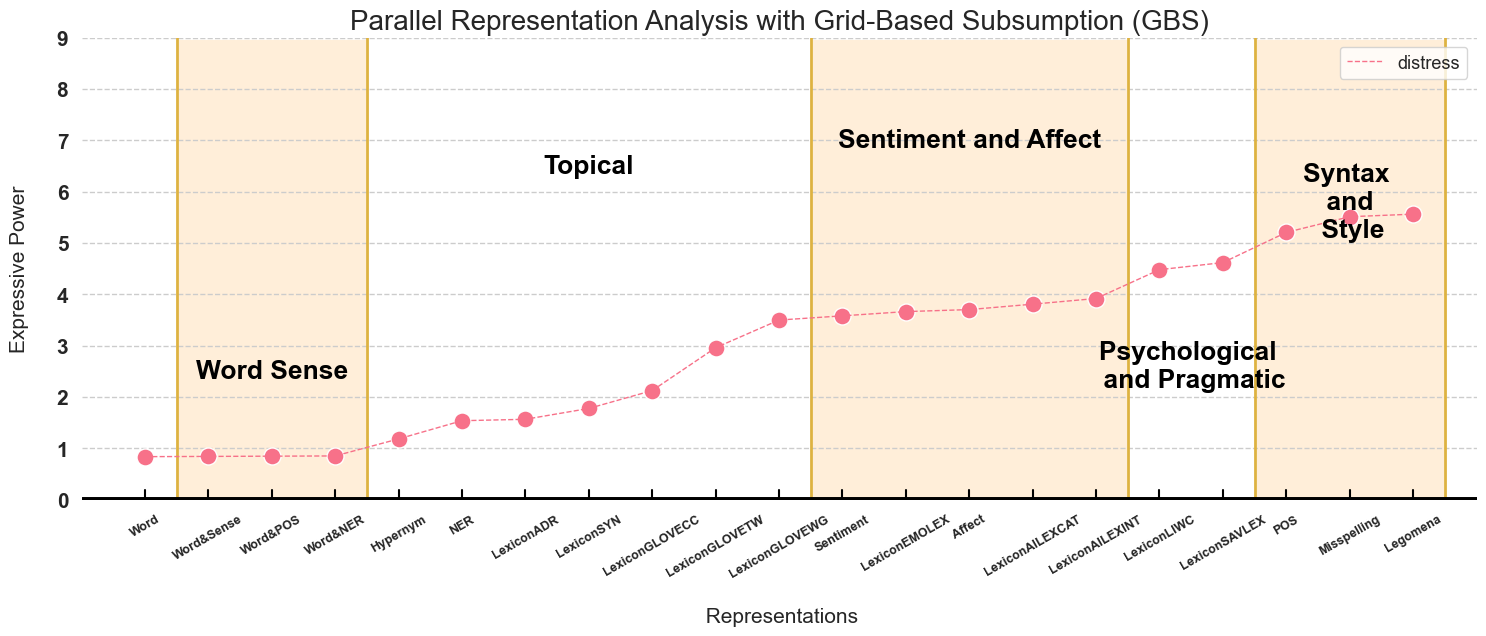

In [19]:
### Set the parameters ###
textagon_output_folder = folder_path
data_name = 'distress'
analysis_output_addr = './'


### Below is code do not need to change ###
if 'result_GBS.csv' not in os.listdir(textagon_output_folder):
    raise ValueError(f'The result file is not in the folder: {textagon_output_folder}')

correct_data = []
column_names = ["Path", "Index", "Category", "Total", "Number", "Ratio"]
df = pd.read_csv(f'{textagon_output_folder}/result_GBS.csv', names=column_names)
category_ratio_dict = df.set_index('Category')['Ratio'].to_dict()
c = 0
for key in category_ratio_dict.keys():
    c += category_ratio_dict[key]
    category_ratio_dict[key] = c
correct_data.append(category_ratio_dict)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
import re

x_axis = ['Word', 'Word&Sense', 'Word&POS', 'Word&NER', 'Hypernym', 'NER', 'LexiconADR', 'LexiconSYN', 'LexiconGLOVECC', 'LexiconGLOVETW', 'LexiconGLOVEWG', 'Sentiment', 'LexiconEMOLEX', 'Affect', 'LexiconAILEXCAT', 'LexiconAILEXINT', 'LexiconLIWC', 'LexiconSAVLEX', 'POS', 'Misspelling', 'Legomena']

fig, ax = plt.subplots(figsize=(18, 6)) 
line_styles = [ '--', '-.']

def plot_data(data, label, linestyle, linewidth, color):
    sorted_data = {k: data[k] if k in data else 0 for k in x_axis}
    sns.lineplot(x=x_axis, y=list(sorted_data.values()), sort=False, linewidth=linewidth, linestyle=linestyle, ax=ax, label=data_name, color=color)
    sns.scatterplot(x=x_axis, y=list(sorted_data.values()), s=150, ax=ax, color=color)
    # for i, y in enumerate(list(sorted_data.values())):
    #     ax.text(i, y, f'{y:.2f}', color=color, ha='center', va='bottom')


highlighted_label = 'FCE/ASAP Human/ChatGPT'
# palette = sns.color_palette(['#9236f5', '#3ea4ed', '#20ab5c', '#e38c22'])
palette = sns.color_palette("husl", len(correct_data))
palette = [color for color in palette if not np.allclose(color, (1.0, 0.0, 0.0))]
# palette = sns.color_palette("husl", len(correct_data))

for i, data in enumerate(correct_data):
    # if legend_names[i] == highlighted_label:
    #     plot_data(data, legend_names[i], '-', 4.5, 'red')
    # else:
    plot_data(data, data_name, line_styles[i % len(line_styles)], (i % 3) + 1, palette[i % len(palette)])

ax.legend()

rectangle_1 = patches.Rectangle((0.5, 0), 3, 9, linewidth=2, facecolor='#FFEED9', fill=True, zorder=0)
rectangle_1.set_clip_on(False)
plt.axvline(0.5, 0, 8.5, color='#DEB240', linewidth=2, zorder=1)
plt.axvline(3.5, 0, 8.5, color='#DEB240', linewidth=2, zorder=1)
ax.add_patch(rectangle_1)

rectangle_2 = patches.Rectangle((10.5, 0), 5, 9, linewidth=2, facecolor='#FFEED9', fill=True, zorder=0)
rectangle_2.set_clip_on(False)
plt.axvline(10.5, 0, 8.5, color='#DEB240', linewidth=2, zorder=1)
plt.axvline(15.5, 0, 8.5, color='#DEB240', linewidth=2, zorder=1)
ax.add_patch(rectangle_2)

rectangle_3 = patches.Rectangle((17.5, 0), 3, 9, linewidth=2, facecolor='#FFEED9', fill=True, zorder=0)
rectangle_3.set_clip_on(False)
plt.axvline(17.5, 0, 8.5, color='#DEB240', linewidth=2, zorder=1)
plt.axvline(20.5, 0, 8.5, color='#DEB240', linewidth=2, zorder=1)
ax.add_patch(rectangle_3)

plt.text(2, 2.5, 'Word Sense', horizontalalignment='center', verticalalignment='center', fontsize=19, color='black', weight='bold')
plt.text(7, 6.5, 'Topical', horizontalalignment='center', verticalalignment='center', fontsize=19, color='black', weight='bold')
plt.text(13, 7, 'Sentiment and Affect', horizontalalignment='center', verticalalignment='center', fontsize=19, color='black', weight='bold')
plt.text(16.5, 2.6, 'Psychological \n and Pragmatic', horizontalalignment='center', verticalalignment='center', fontsize=19, color='black', weight='bold')
plt.text(19, 5.8, 'Syntax \n and \n Style', horizontalalignment='center', verticalalignment='center', fontsize=19, color='black', weight='bold')

plt.axhline(0, color='black', linewidth=5, zorder=1)
plt.xticks(rotation=45, weight='bold', fontsize=15)
plt.yticks(weight='bold', fontsize=15)

sns.despine(top=True, right=True, left=True, bottom=True)
sns.set_style("whitegrid")
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.linestyle': '--'})
ax.xaxis.grid(False)
ax.set_ylim(0, 9)
ax.legend(fontsize=13)
ax.set_xticklabels(x_axis, rotation=30, weight='bold', fontsize=9)

def add_ticks_for_labels():
    for i, _ in enumerate(x_axis):
        ax.axvline(i, 0, 0.02, color='black')  # Here, 0.02 defines the length of the tick relative to y-axis
add_ticks_for_labels() 

plt.xlabel("\n Representations", fontsize=15)
plt.ylabel("Expressive Power\n", fontsize=15)
plt.title("Parallel Representation Analysis with Grid-Based Subsumption (GBS)", fontsize=20)

plt.savefig(f'{analysis_output_addr}/GBS_{data_name}.pdf', bbox_inches='tight')

plt.show()
